In [ ]:
# Aligns a score volume with an annotation volume

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

import logging

In [3]:
volume_dir = '/oasis/projects/nsf/csd395/yuncong/CSHL_volumes/'

atlasAlignOptLogs_dir = create_if_not_exists('/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignOptLogs_atlas')
atlasAlignParams_dir = create_if_not_exists('/oasis/projects/nsf/csd395/yuncong/CSHL_atlasAlignParams_atlas')

In [4]:
volume_landmark_names_unsided = ['12N', '5N', '6N', '7N', '7n', 'AP', 'Amb', 'LC',
                                 'LRt', 'Pn', 'R', 'RtTg', 'Tz', 'VLL', 'sp5']
linear_landmark_names_unsided = ['outerContour']

labels_unsided = volume_landmark_names_unsided + linear_landmark_names_unsided
labels_unsided_indices = dict((j, i+1) for i, j in enumerate(labels_unsided))  # BackG always 0

labelMap_unsidedToSided = {'12N': ['12N'],
                            '5N': ['5N_L', '5N_R'],
                            '6N': ['6N_L', '6N_R'],
                            '7N': ['7N_L', '7N_R'],
                            '7n': ['7n_L', '7n_R'],
                            'AP': ['AP'],
                            'Amb': ['Amb_L', 'Amb_R'],
                            'LC': ['LC_L', 'LC_R'],
                            'LRt': ['LRt_L', 'LRt_R'],
                            'Pn': ['Pn_L', 'Pn_R'],
                            'R': ['R_L', 'R_R'],
                            'RtTg': ['RtTg'],
                            'Tz': ['Tz_L', 'Tz_R'],
                            'VLL': ['VLL_L', 'VLL_R'],
                            'sp5': ['sp5'],
                           'outerContour': ['outerContour']}

labelMap_sidedToUnsided = {n: nu for nu, ns in labelMap_unsidedToSided.iteritems() for n in ns}

from itertools import chain
labels_sided = list(chain(*(labelMap_unsidedToSided[name_u] for name_u in labels_unsided)))
labels_sided_indices = dict((j, i+1) for i, j in enumerate(labels_sided)) # BackG always 0

In [5]:
# atlas_volume = bp.unpack_ndarray_file(os.path.join(volume_dir, 'MD589/volume_MD589_annotation_withOuterContour.bp'))
atlas_volume = bp.unpack_ndarray_file(volume_dir + '/atlasVolume_icp.bp')

atlas_ydim, atlas_xdim, atlas_zdim = atlas_volume.shape
atlas_centroid = np.array([.5*atlas_xdim, .5*atlas_ydim, .5*atlas_zdim])
print atlas_centroid

[ 303.   200.5  265.5]


In [6]:
available_labels_sided = [labels_sided[i-1] for i in np.unique(atlas_volume) if i > 0]
available_labels_unsided = set([labelMap_sidedToUnsided[name] for name in available_labels_sided ])

In [7]:
def parallel_where(name, num_samples=None):
    
    w = np.where(atlas_volume == labels_sided_indices[name])
    
    if num_samples is not None:
        n = len(w[0])
        sample_indices = np.random.choice(range(n), min(num_samples, n), replace=False)
        return np.c_[w[1][sample_indices].astype(np.int16), 
                     w[0][sample_indices].astype(np.int16), 
                     w[2][sample_indices].astype(np.int16)]
    else:
        return np.c_[w[1].astype(np.int16), w[0].astype(np.int16), w[2].astype(np.int16)]

t = time.time()

atlas_nzs = Parallel(n_jobs=16)(delayed(parallel_where)(name_s, num_samples=int(1e5)) for name_s in available_labels_sided)
atlas_nzs = dict(zip(available_labels_sided, atlas_nzs))

sys.stderr.write('load atlas: %f seconds\n' % (time.time() - t)) #~ 7s

load atlas: 2.121395 seconds


In [8]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [9]:
pts_centered = {name: (np.concatenate([atlas_nzs[n] for n in labelMap_unsidedToSided[name]]) - atlas_centroid).astype(np.int16) 
                         for name in available_labels_unsided}

In [10]:
# label_weights = {name: 0 if name == 'outerContour' else 1. for name in labels_unsided[1:]}
label_weights = {name: .1 if name == 'outerContour' else 1. for name in available_labels_unsided}

In [11]:
def compute_score_and_gradient(T):
    global pts_centered
    
    score = 0
    dMdA = np.zeros((12,))
    
    for name in available_labels_unsided:
#         t1 = time.time()
    
        pts_prime = transform_points(T, pts_centered=pts_centered[name], c_prime=test_centroid)
        
        xs_prime, ys_prime, zs_prime = pts_prime.T.astype(np.int16)

        valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
                (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
                   
        if np.count_nonzero(valid) > 0:

            xs_prime_valid = xs_prime[valid]
            ys_prime_valid = ys_prime[valid]
            zs_prime_valid = zs_prime[valid]
            
            voxel_probs_valid = volume2_allLabels[name][ys_prime_valid, xs_prime_valid, zs_prime_valid] / 1e4

            score += label_weights[name] * voxel_probs_valid.sum()
            
            Sx = dSdxyz[name][0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sy = dSdxyz[name][1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sz = dSdxyz[name][2, ys_prime_valid, xs_prime_valid, zs_prime_valid]
            
            dxs, dys, dzs = pts_centered[name][valid].T

            q = np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
                          Sy*dxs, Sy*dys, Sy*dzs, Sy,
                          Sz*dxs, Sz*dys, Sz*dzs, Sz]        
            
            dMdA += label_weights[name] * q.sum(axis=0)
            
            del voxel_probs_valid, q, Sx, Sy, Sz, dxs, dys, dzs, xs_prime_valid, ys_prime_valid, zs_prime_valid
        
#         sys.stderr.write('########### %s: %f seconds\n' % (labels[l], time.time() - t1))
        
        del valid, xs_prime, ys_prime, zs_prime, pts_prime
        
    return score, dMdA

In [12]:
def compute_score(T):
    
    score = 0
    for name in available_labels_unsided:
        
        pts_prime = transform_points(T, pts_centered=pts_centered[name], c_prime=test_centroid)
    
        xs_prime, ys_prime, zs_prime = pts_prime.T.astype(np.int16)
        
        valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
            
        voxel_probs_valid = volume2_allLabels[name][ys_prime[valid], xs_prime[valid], zs_prime[valid]] / 1e4

        score += label_weights[name] * voxel_probs_valid.sum()
                
        del voxel_probs_valid, valid, xs_prime, ys_prime, zs_prime, pts_prime
                
    return score

def compute_score_gradient(T):

    dMdA = np.zeros((12,))

    for name in available_labels_unsided:
#       
        pts_prime = transform_points(T, pts_centered=pts_centered[name], c_prime=test_centroid)

        xs_prime, ys_prime, zs_prime = pts_prime.T.astype(np.int16)

        valid = (xs_prime >= 0) & (ys_prime >= 0) & (zs_prime >= 0) & \
            (xs_prime < test_xdim) & (ys_prime < test_ydim) & (zs_prime < test_zdim)
            
        if np.count_nonzero(valid) > 0:
            
            xs_prime_valid = xs_prime[valid]
            ys_prime_valid = ys_prime[valid]
            zs_prime_valid = zs_prime[valid]
            
            Sx = dSdxyz[name][0, ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sy = dSdxyz[name][1, ys_prime_valid, xs_prime_valid, zs_prime_valid]
            Sz = dSdxyz[name][2, ys_prime_valid, xs_prime_valid, zs_prime_valid]
               
            dxs, dys, dzs = pts_centered[name][valid].T
                        
            dMdA += label_weights[name] * np.c_[Sx*dxs, Sx*dys, Sx*dzs, Sx, 
                          Sy*dxs, Sy*dys, Sy*dzs, Sy,
                          Sz*dxs, Sz*dys, Sz*dzs, Sz].sum(axis=0)
            
    return dMdA

load score volumes: 33.129031 seconds
load gradient RtTg: 8.678933 seconds
load gradient VLL: 8.766556 seconds
load gradient Tz: 6.795144 seconds
load gradient LC: 7.191441 seconds
load gradient 7N: 7.374749 seconds
load gradient Amb: 6.503481 seconds
load gradient 6N: 14.649255 seconds
load gradient AP: 8.815282 seconds
load gradient 5N: 13.104009 seconds
load gradient 12N: 11.023642 seconds
load gradient 7n: 11.301693 seconds
load gradient R: 14.008791 seconds
load gradient Pn: 17.779434 seconds
load gradient LRt: 15.594274 seconds
overall: 151.592230 seconds
INFO:__main__:grid search iteration 0


test_xdim, test_ydim, test_zdim: 1056 472 437
test_centroid: [ 528.   236.   218.5]


grid search: 28.949753 seconds
INFO:__main__:0.000000 18.598332
INFO:__main__:-32.637393 32.914892 -27.375946
INFO:__main__:

INFO:__main__:grid search iteration 1
grid search: 22.733895 seconds
INFO:__main__:18.598332 20.424042
INFO:__main__:-58.801094 13.847452 6.066489
INFO:__main__:

INFO:__main__:grid search iteration 2
grid search: 17.753923 seconds
INFO:__main__:20.424042 20.483360
INFO:__main__:-37.485847 23.766837 7.384356
INFO:__main__:

INFO:__main__:grid search iteration 3
grid search: 13.520829 seconds
INFO:__main__:20.483360 23.471802
INFO:__main__:-55.335922 17.154116 -7.921151
INFO:__main__:

INFO:__main__:grid search iteration 4
grid search: 10.277319 seconds
INFO:__main__:

INFO:__main__:iteration 0
INFO:__main__:score: 23.471802
INFO:__main__:

INFO:__main__:iteration 1
INFO:__main__:score: 28.264053
INFO:__main__:

INFO:__main__:iteration 2
INFO:__main__:score: 32.149796
INFO:__main__:

INFO:__main__:iteration 3
INFO:__main__:score: 33.800346
INFO:__main__:

INFO:__

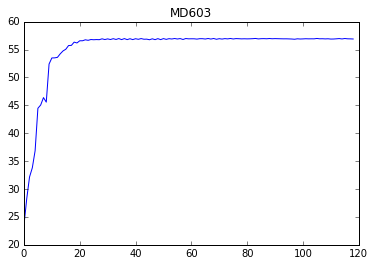

In [14]:
# For all stacks

# for stack in ['MD594', 'MD593', 'MD585', 'MD592', 'MD590', 'MD591', 'MD595', 'MD598', 'MD602']:
for stack in ['MD603']:
    # will do for MD589, MD603 later
    
    ################# Load Test Volume ######################

    t = time.time()

    volume2_allLabels = {}

    for name in available_labels_unsided:

        if name == 'BackG':
            continue

        volume2_roi = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_%(label)s.bp' % \
                                                          {'stack': stack, 'label': name})).astype(np.float16)
        volume2_allLabels[name] = volume2_roi
        del volume2_roi

    test_ydim, test_xdim, test_zdim = volume2_allLabels.values()[0].shape
    test_centroid = np.r_[.5*test_xdim, .5*test_ydim, .5*test_zdim]

    print 'test_xdim, test_ydim, test_zdim:', test_xdim, test_ydim, test_zdim
    print 'test_centroid:', test_centroid

    sys.stderr.write('load score volumes: %f seconds\n' % (time.time() - t))

    ###################### Load Gradient #####################

    dSdxyz = {name: np.empty((3, test_ydim, test_xdim, test_zdim), dtype=np.float16) for name in available_labels_unsided}

    t1 = time.time()

    for name in available_labels_unsided:

        if name == 'BackG':
            continue

        t = time.time()

        dSdxyz[name][0] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gx.bp' % {'stack':stack, 'label':name})
        dSdxyz[name][1] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gy.bp' % {'stack':stack, 'label':name})
        dSdxyz[name][2] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gz.bp' % {'stack':stack, 'label':name})

        sys.stderr.write('load gradient %s: %f seconds\n' % (name, time.time() - t)) # ~6s

    sys.stderr.write('overall: %f seconds\n' % (time.time() - t1)) # ~100s
    
    handler = logging.FileHandler(atlasAlignOptLogs_dir + '/%(stack)s_atlasAlignOpt.log' % {'stack': stack})
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    ################# Random Grid Search ######################

    grid_search_iteration_number = 5
    # grid_search_iteration_number = 1

    params_best_upToNow = (0, 0, 0)
    score_best_upToNow = 0

    init_n = 1000

    for iteration in range(grid_search_iteration_number):

        logger.info('grid search iteration %d', iteration)

        init_tx, init_ty, init_tz  = params_best_upToNow

        n = int(init_n*np.exp(-iteration/3.))

        sigma_tx = 300*np.exp(-iteration/3.)
        sigma_ty = 300*np.exp(-iteration/3.)
        sigma_tz = 100*np.exp(-iteration/3.)

        tx_grid = init_tx + sigma_tx * (2 * np.random.random(n) - 1)
        ty_grid = init_ty + sigma_ty * (2 * np.random.random(n) - 1)
        tz_grid = init_tz + sigma_tz * (2 * np.random.random(n) - 1)

        samples = np.c_[tx_grid, ty_grid, tz_grid]

        import time

        t = time.time()
        # num jobs * memory each job

        scores = Parallel(n_jobs=8)(delayed(compute_score)(np.r_[1, 0, 0, tx, 0, 1, 0, ty, 0, 0, 1, tz])
                                    for tx, ty, tz in samples)

    #     scores = []
    #     for tx, ty, tz in samples:
    #         scores.append(compute_score([1, 0, 0, tx, 0, 1, 0, ty, 0, 0, 1, tz]))

        sys.stderr.write('grid search: %f seconds\n' % (time.time() - t)) # ~23s

        score_best = np.max(scores)

        tx_best, ty_best, tz_best = samples[np.argmax(scores)]

        if score_best > score_best_upToNow:
            logger.info('%f %f', score_best_upToNow, score_best)

            score_best_upToNow = score_best
            params_best_upToNow = tx_best, ty_best, tz_best

            logger.info('%f %f %f', tx_best, ty_best, tz_best)

        logger.info('\n')
        
    ################# Gradient Descent ######################

    lr1, lr2 = (10., 1e-1)
    # lr1, lr2 = (1., 1e-3)

    # auto_corr = .95

    max_iter_num = 1000
    fudge_factor = 1e-6 #for numerical stability
    dMdA_historical = np.zeros((12,))

    tx_best, ty_best, tz_best = params_best_upToNow
    T_best = np.r_[1,0,0, tx_best, 0,1,0, ty_best, 0,0,1, tz_best]

    lr = np.r_[lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1]

    score_best = 0

    scores = []

    for iteration in range(max_iter_num):

        logger.info('iteration %d', iteration)

    #     t = time.time()
        s, dMdA = compute_score_and_gradient(T_best)
    #     sys.stderr.write('compute_score_and_gradient: %f seconds\n' % (time.time() - t)) #~ 2s/iteration or ~.5s: 1e5 samples per landmark

        dMdA_historical += dMdA**2
    #     dMdA_historical = auto_corr * dMdA_historical + (1-auto_corr) * dMdA**2

        dMdA_adjusted = dMdA / (fudge_factor + np.sqrt(dMdA_historical))

        T_best += lr*dMdA_adjusted

    #         logger.info('A: ' + ' '.join(['%f']*12) % tuple(A_best))
    #         logger.info('dMdA adjusted: ' + ' '.join(['%f']*12) % tuple(dMdA_adjusted))

        logger.info('score: %f', s)
        scores.append(s)

        logger.info('\n')

        history_len = 50
        if iteration > 100:
            if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                      np.mean(scores[iteration-2*history_len:iteration-history_len])) < 1e-1:
                break

        if s > score_best:
    #             logger.info('Current best')
            best_gradient_descent_params = T_best
            score_best = s

    plt.title('%s' % stack);
    plt.plot(scores);
    plt.show();
    
    del volume2_allLabels, dSdxyz
    
    ################# Save results ###############
    
    np.save(atlasAlignOptLogs_dir + '/%(stack)s_scoreEvolutions.npy' % {'stack':stack}, scores)
    
    create_if_not_exists(os.path.join(atlasAlignParams_dir + '/' + stack))
    with open(os.path.join(atlasAlignParams_dir, '%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack':stack}), 'w') as f:

        f.writelines(' '.join(['%f']*len(best_gradient_descent_params)) % tuple(best_gradient_descent_params) + '\n')
        f.write((' '.join(['%d']*3)+'\n') % tuple([atlas_xdim, atlas_ydim, atlas_zdim]))
        f.write((' '.join(['%.1f']*3)+'\n') % tuple(atlas_centroid))    
        f.write((' '.join(['%d']*3)+'\n') % tuple([test_xdim, test_ydim, test_zdim]))
        f.write((' '.join(['%.1f']*3)+'\n') % tuple(test_centroid))

In [ ]:
# single stack

In [ ]:
stack = 'MD585'

In [ ]:
################# Load Test Volume ######################

t = time.time()

volume2_allLabels = {}

for name in available_labels_unsided:

    if name == 'BackG':
        continue

    volume2_roi = bp.unpack_ndarray_file(os.path.join(volume_dir, '%(stack)s/%(stack)s_scoreVolume_%(label)s.bp' % \
                                                      {'stack': stack, 'label': name})).astype(np.float16)
    volume2_allLabels[name] = volume2_roi
    del volume2_roi

test_ydim, test_xdim, test_zdim = volume2_allLabels.values()[0].shape
test_centroid = np.r_[.5*test_xdim, .5*test_ydim, .5*test_zdim]

print 'test_xdim, test_ydim, test_zdim:', test_xdim, test_ydim, test_zdim
print 'test_centroid:', test_centroid

# test_xdim = volume_xmax - volume_xmin + 1
# test_ydim = volume_ymax - volume_ymin + 1
# test_zdim = volume_zmax - volume_zmin + 1

sys.stderr.write('load score volumes: %f seconds\n' % (time.time() - t))

###################### Load Gradient #####################

dSdxyz = {name: np.empty((3, test_ydim, test_xdim, test_zdim), dtype=np.float16) for name in available_labels_unsided}

t1 = time.time()

for name in available_labels_unsided:

    if name == 'BackG':
        continue

    t = time.time()

    dSdxyz[name][0] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gx.bp' % {'stack':stack, 'label':name})
    dSdxyz[name][1] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gy.bp' % {'stack':stack, 'label':name})
    dSdxyz[name][2] = bp.unpack_ndarray_file(volume_dir + '/%(stack)s/%(stack)s_scoreVolume_%(label)s_gz.bp' % {'stack':stack, 'label':name})

    sys.stderr.write('load gradient %s: %f seconds\n' % (name, time.time() - t)) # ~6s

sys.stderr.write('overall: %f seconds\n' % (time.time() - t1)) # ~100s

In [ ]:
handler = logging.FileHandler(atlasAlignOptLogs_dir + '/%(stack)s_atlasAlignOpt.log' % {'stack': stack})
handler.setLevel(logging.INFO)
logger.addHandler(handler)

################# Random Grid Search ######################

grid_search_iteration_number = 5
# grid_search_iteration_number = 1

params_best_upToNow = (0, 0, 0)
score_best_upToNow = 0

init_n = 1000

for iteration in range(grid_search_iteration_number):

    logger.info('grid search iteration %d', iteration)

    init_tx, init_ty, init_tz  = params_best_upToNow

    n = int(init_n*np.exp(-iteration/3.))

    sigma_tx = 300*np.exp(-iteration/3.)
    sigma_ty = 300*np.exp(-iteration/3.)
    sigma_tz = 100*np.exp(-iteration/3.)

    tx_grid = init_tx + sigma_tx * (2 * np.random.random(n) - 1)
    ty_grid = init_ty + sigma_ty * (2 * np.random.random(n) - 1)
    tz_grid = init_tz + sigma_tz * (2 * np.random.random(n) - 1)

    samples = np.c_[tx_grid, ty_grid, tz_grid]

    import time

    t = time.time()
    # num jobs * memory each job
    
    scores = Parallel(n_jobs=8)(delayed(compute_score)(np.r_[1, 0, 0, tx, 0, 1, 0, ty, 0, 0, 1, tz])
                                for tx, ty, tz in samples)

#     scores = []
#     for tx, ty, tz in samples:
#         scores.append(compute_score([1, 0, 0, tx, 0, 1, 0, ty, 0, 0, 1, tz]))
                                
    sys.stderr.write('grid search: %f seconds\n' % (time.time() - t)) # ~23s
    
    score_best = np.max(scores)

    tx_best, ty_best, tz_best = samples[np.argmax(scores)]

    if score_best > score_best_upToNow:
        logger.info('%f %f', score_best_upToNow, score_best)

        score_best_upToNow = score_best
        params_best_upToNow = tx_best, ty_best, tz_best

        logger.info('%f %f %f', tx_best, ty_best, tz_best)
    
    logger.info('\n')

In [ ]:
################# Gradient Descent ######################

lr1, lr2 = (10., 1e-1)
# lr1, lr2 = (1., 1e-3)

# auto_corr = .95

max_iter_num = 1000
fudge_factor = 1e-6 #for numerical stability
dMdA_historical = np.zeros((12,))

tx_best, ty_best, tz_best = params_best_upToNow
T_best = np.r_[1,0,0, tx_best, 0,1,0, ty_best, 0,0,1, tz_best]

lr = np.r_[lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1, lr2, lr2, lr2, lr1]

score_best = 0

scores = []

for iteration in range(max_iter_num):

    logger.info('iteration %d', iteration)

#     t = time.time()
    s, dMdA = compute_score_and_gradient(T_best)
#     sys.stderr.write('compute_score_and_gradient: %f seconds\n' % (time.time() - t)) #~ 2s/iteration or ~.5s: 1e5 samples per landmark

    dMdA_historical += dMdA**2
#     dMdA_historical = auto_corr * dMdA_historical + (1-auto_corr) * dMdA**2

    dMdA_adjusted = dMdA / (fudge_factor + np.sqrt(dMdA_historical))

    T_best += lr*dMdA_adjusted

#         logger.info('A: ' + ' '.join(['%f']*12) % tuple(A_best))
#         logger.info('dMdA adjusted: ' + ' '.join(['%f']*12) % tuple(dMdA_adjusted))

    logger.info('score: %f', s)
    scores.append(s)

    logger.info('\n')

    history_len = 50
    if iteration > 100:
        if np.abs(np.mean(scores[iteration-history_len:iteration]) - \
                  np.mean(scores[iteration-2*history_len:iteration-history_len])) < 1e-1:
            break

    if s > score_best:
#             logger.info('Current best')
        best_gradient_descent_params = T_best
        score_best = s

plt.plot(scores);

In [ ]:
np.save(atlasAlignOptLogs_dir + '/%(stack)s_scoreEvolutions.npy' % {'stack':stack}, scores)

In [ ]:
with open(os.path.join(atlasAlignParams_dir, '%(stack)s/%(stack)s_3dAlignParams.txt' % {'stack':stack}), 'w') as f:

    f.writelines(' '.join(['%f']*len(best_gradient_descent_params)) % tuple(best_gradient_descent_params) + '\n')
    f.write((' '.join(['%d']*3)+'\n') % tuple([atlas_xdim, atlas_ydim, atlas_zdim]))
    f.write((' '.join(['%.1f']*3)+'\n') % tuple(atlas_centroid))    
    f.write((' '.join(['%d']*3)+'\n') % tuple([test_xdim, test_ydim, test_zdim]))
    f.write((' '.join(['%.1f']*3)+'\n') % tuple(test_centroid))